#  06. Transfer Learning in TensorFlow Part 3: Scaling-up Exercises

In [21]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2023-12-15 11:07:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-15 11:07:10 (68.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Exercise 1: Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.

### Loading and preprocessing the data

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")


--2023-12-15 11:07:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  86.8MB/s    in 20s     

2023-12-15 11:07:31 (77.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/escargots'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_bolognese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pancakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101

In [5]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory("101_food_classes_10_percent/train/",
                                                                  label_mode="categorical",
                                                                  image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory("101_food_classes_10_percent/test/",
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Adding some data augmentation

In [6]:
## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


### Creating the model

In [7]:
# We create a model checkpoint to save our model
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file

In [8]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False;

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
# Put the base model in inference mode so we can use it to extract features without
#updati
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

24274472/24274472 [==============================] - 0s 0us/step


In [9]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

### Compiling and Fitting

In [11]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history = model_1.fit(train_data,
            epochs=5,
            validation_data=test_data,
            validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
            callbacks=[checkpoint_callback]) # save best model weights to file)

Epoch 1/5
237/237 [==============================] - 169s 682ms/step - loss: 2.7440 - accuracy: 0.3848 - val_loss: 2.3777 - val_accuracy: 0.4571
Epoch 2/5
237/237 [==============================] - 117s 489ms/step - loss: 2.1648 - accuracy: 0.4956 - val_loss: 2.0807 - val_accuracy: 0.4981
Epoch 3/5
237/237 [==============================] - 96s 403ms/step - loss: 1.9126 - accuracy: 0.5422 - val_loss: 1.9838 - val_accuracy: 0.5069
Epoch 4/5
237/237 [==============================] - 91s 385ms/step - loss: 1.7233 - accuracy: 0.5805 - val_loss: 1.8614 - val_accuracy: 0.5289
Epoch 5/5
237/237 [==============================] - 80s 338ms/step - loss: 1.6142 - accuracy: 0.6003 - val_loss: 1.8262 - val_accuracy: 0.5326


In [12]:
model_1.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.5832 - accuracy: 0.5830


[1.583194613456726, 0.5829703211784363]

### Fine-Tunning

In [13]:
# Unfreezing 5 layers
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [14]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [15]:
history_fine_tunned = model_1.fit(train_data,
                                  epochs=10,
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)),
                                  initial_epoch=history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 87s 328ms/step - loss: 1.4325 - accuracy: 0.6368 - val_loss: 1.7884 - val_accuracy: 0.5320
Epoch 6/10
237/237 [==============================] - 64s 270ms/step - loss: 1.3173 - accuracy: 0.6577 - val_loss: 1.7758 - val_accuracy: 0.5392
Epoch 7/10
237/237 [==============================] - 67s 279ms/step - loss: 1.2830 - accuracy: 0.6647 - val_loss: 1.7776 - val_accuracy: 0.5368
Epoch 8/10
237/237 [==============================] - 57s 239ms/step - loss: 1.2416 - accuracy: 0.6776 - val_loss: 1.7856 - val_accuracy: 0.5371
Epoch 9/10
237/237 [==============================] - 50s 210ms/step - loss: 1.1993 - accuracy: 0.6838 - val_loss: 1.7452 - val_accuracy: 0.5487
Epoch 10/10
237/237 [==============================] - 58s 245ms/step - loss: 1.1730 - accuracy: 0.6931 - val_loss: 1.7970 - val_accuracy: 0.5342


In [16]:
model_1.evaluate(test_data)

790/790 [==============================] - 51s 65ms/step - loss: 1.4850 - accuracy: 0.6032


[1.4849568605422974, 0.6032475233078003]

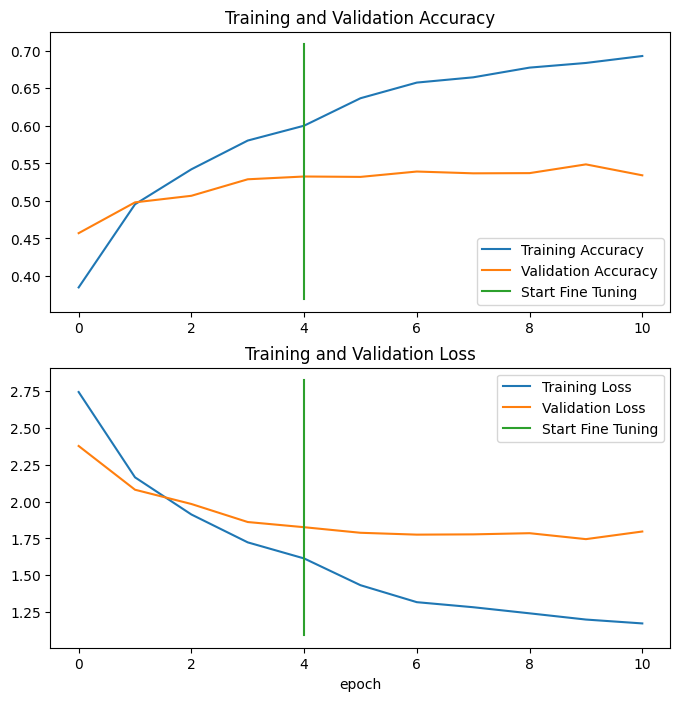

In [17]:
compare_historys(original_history=history,
                 new_history=history_fine_tunned,
                 initial_epochs=5)

### Making predictions

In [22]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 47ms/step


FailedPreconditionError: ignored

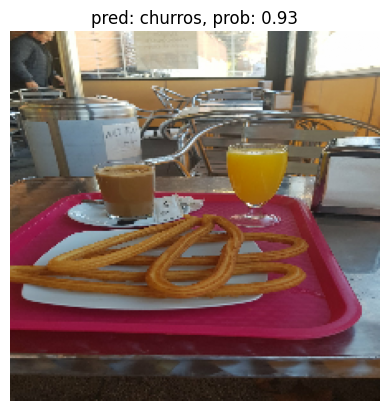

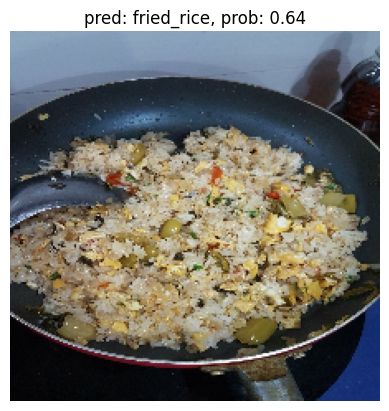

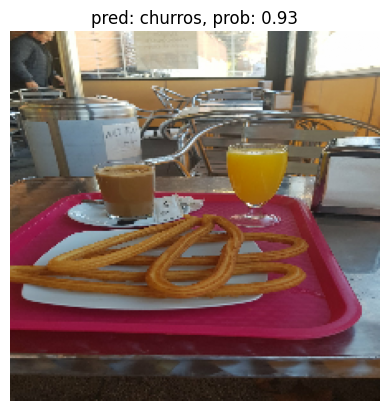

In [29]:
unzip_data("CustomFoodImages.zip")

# Get custom food images filepaths
custom_food_images = ["CustomFoodImages/" + img_path for img_path in os.listdir("CustomFoodImages")]

# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = train_data.class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

## Exercise 2: Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in exercise 1). Which method is better?

In [ ]:
base_model_2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model_2.trainable = False;

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
# Put the base model in inference mode so we can use it to extract features without
#updati
x = base_model_2(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
            epochs=10,
            validation_data=test_data,
            validation_steps=int(0.15 * len(test_data))) # evaluate on smaller portion of test data)

In [ ]:
model_2.evaluate(test_data)

In [ ]:
plot_loss_curves(history)

In [ ]:
plot_loss_curves(history_2)

**Therefore we conclude that the first model fine-tunned does best.**

## Exercise 3: Recreate the first model (the feature extraction model) with mixed_precision turned on.
  * Does it make the model train faster?
  * Does it effect the accuracy or performance of our model?
  * What's the advantages of using mixed_precision training?

In [ ]:
# Set global policy to mixed precision
from tf.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# And now to make sure it starts at the same checkpoint, we can load the checkpointed
# weights from checkpoint_path:
model_1.load_weights(checkpoint_path)

In [ ]:
history_3 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.15 * len(test_data)))

In [ ]:
model_1.evaluate(test_data)